# Qutip project 7

For more information about QuTiP see [http://qutip.org](http://qutip.org)

Revised by A.S. Ivlev

In [52]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from qutip import *

# 1. Introduction

Hyperfine interaction starts to play a role when the spatial extent of the wavefunctions is significant. For example, an electron spin orbiting a nucleus experience a hyperfine interaction due to the nuclear spin. This impacts the energy of the electron spin. In this notebook, we are going to simulate observations made by Hanson et al. in PhysRevLett.97.087601, where hyperfine interaction plays a significant role in the dynamics of their NV-center experiment.  

First we import the relevant operators of the spin 1 and spin 1/2 systems, together with the Hamiltonian contribution

In [53]:
from spin_operators import S_x, S_y, S_z, S1_x, S1_y, S1_z
from hamiltonians import nitrogen_vacancy_hamiltonian, nitrogen_atom_hamiltonian, dipolar_coupling, hyperfine_coupling

## 2. Eigenstates and energylevels

Before we go into the dynamics of the system, we first look at the static hamiltonian of the system. We can study the different contributions of the Hamiltonian, and the effect of a global megnetic field and coupling terms.  

### 2.1 Individual systems

First look at the NV-center and N atom separately and see what their eigeneigergies look like as a function of magnetic field.

To do so we define the S_x, S_y and S_z operators for the systems. Note that we need an eigenbasis of dimension 6 for the Nitrogen atom, since there is an electron (dim = 2) coupled to the spin 1 nuclues (dim = 3). Where we tensor the individual operators with identities.

In [54]:
nv_ops_subsys = (S1_x, S1_y, S1_z)
n_ops_subsys = (tensor(qeye(3), S_x), tensor(qeye(3), S_y), tensor(qeye(3), S_z))
i_ops_subsys = (tensor(S1_x, qeye(2)), tensor(S1_y, qeye(2)), tensor(S1_z, qeye(2)))

In [55]:
b_fields = np.linspace(0e-4, 0.1, 1001)  # magnetic Field in Tesla
hf_coupling = 86e6  # hyperfine coupling in Hz

N_eigen_energies = np.zeros((6, len(b_fields)))
NV_eigen_energies = np.zeros((3, len(b_fields)))

N_eigen_energies_rwa = np.zeros((6, len(b_fields)))
NV_eigen_energies_rwa = np.zeros((3, len(b_fields)))

for i, field in enumerate(b_fields):
    H_NV = nitrogen_vacancy_hamiltonian(b_field=field, spin_ops=nv_ops_subsys)
    H_N = nitrogen_atom_hamiltonian(b_field=field, hf_coupling=hf_coupling, electron_s_ops=n_ops_subsys, nuclues_s_ops=i_ops_subsys)

    N_eigen_energies[:, i] = H_N.eigenenergies()
    NV_eigen_energies[:, i] = H_NV.eigenenergies()

    H_NV_rwa = nitrogen_vacancy_hamiltonian(b_field=field, spin_ops=(S1_x, S1_y, S1_z))
    H_N_rwa = nitrogen_atom_hamiltonian(b_field=field, hf_coupling=hf_coupling,electron_s_ops=n_ops_subsys, nuclues_s_ops=i_ops_subsys, rwa=True)

    N_eigen_energies_rwa[:, i] = H_N_rwa.eigenenergies()
    NV_eigen_energies_rwa[:, i] = H_NV_rwa.eigenenergies()

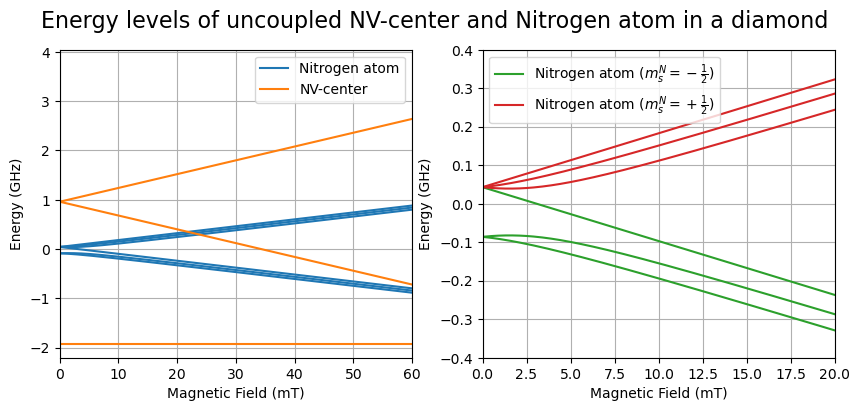

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle('Energy levels of uncoupled NV-center and Nitrogen atom in a diamond', fontsize=16)

for i in range(6):
    if i == 0:
        ax[0].plot(b_fields * 1e3, (N_eigen_energies[i, :] / 1e9).tolist(), label='Nitrogen atom', color='C0')
    else:
        ax[0].plot(b_fields * 1e3, (N_eigen_energies[i, :] / 1e9).tolist(), color='C0')

for i in range(3):
    if i == 0:
        ax[0].plot(b_fields * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), label='NV-center', color='C1')
    else:
        ax[0].plot(b_fields * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), color='C1')

ax[0].set_xlabel('Magnetic Field (mT)')
ax[0].set_ylabel('Energy (GHz)')
ax[0].set_xlim(0, 600e-1)

ax[0].grid()
ax[0].legend()

for i in range(3):
    if i == 0:
        ax[1].plot(b_fields * 1e3, (N_eigen_energies[i, :] / 1e9).tolist(), label=r'Nitrogen atom ($m^{N}_s = -\frac{1}{2}$)', color='C2')
    else:
        ax[1].plot(b_fields * 1e3, (N_eigen_energies[i, :] / 1e9).tolist(), color='C2')

for i in range(3):
    if i == 0:
        ax[1].plot(b_fields * 1e3, (N_eigen_energies[i + 3, :] / 1e9).tolist(), label=r'Nitrogen atom ($m^{N}_s = +\frac{1}{2}$)', color='C3')
    else:
        ax[1].plot(b_fields * 1e3, (N_eigen_energies[i + 3, :] / 1e9).tolist(), color='C3')

ax[1].set_xlabel('Magnetic Field (mT)')
ax[1].set_ylabel('Energy (GHz)')
ax[1].set_xlim(0, 200e-1)
ax[1].set_ylim(-0.4, 0.4)
ax[1].grid()
ax[1].legend()

plt.show()

fig.savefig('uncoupled_energy_levels.png', dpi=500, bbox_inches='tight')

C:\Users\Roald\AppData\Local\Temp\ipykernel_24372\3908315228.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


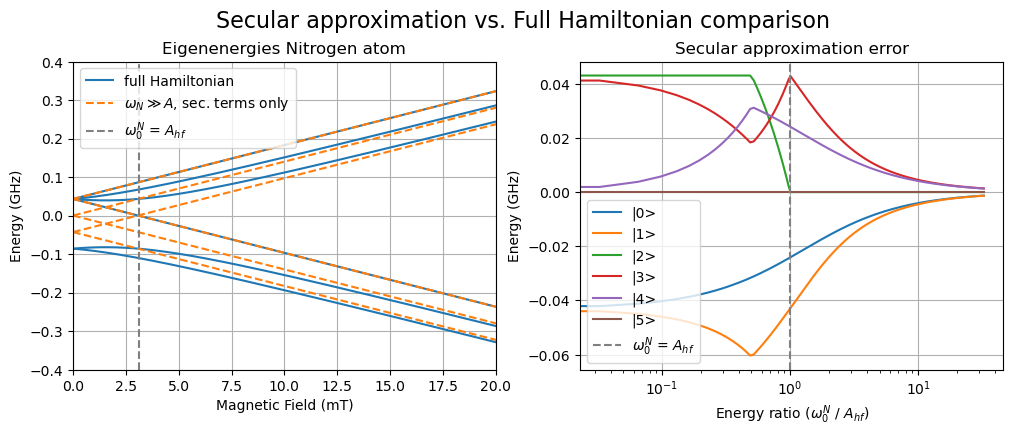

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

from scipy.constants import elementary_charge, Planck
from scipy.constants import physical_constants

BOHR_MAGNETON_EV = physical_constants['Bohr magneton in eV/T'][0]
G_NV = 2  # electron g-factor
G_N = 2  # electron g-factor

coupling_ratios = G_NV * BOHR_MAGNETON_EV * b_fields * elementary_charge / (Planck) / hf_coupling
complete_hybridization_field = b_fields[np.argmin(np.abs(coupling_ratios - 1))]



fig.suptitle('Secular approximation vs. Full Hamiltonian comparison', fontsize=16, y=1.01)

for i in range(6):
    if i == 0:
        ax[0].plot(b_fields * 1e3, (N_eigen_energies[i, :] / 1e9).tolist(),
                   label='full Hamiltonian',
                   color='C0')
    else:
        ax[0].plot(b_fields * 1e3, (N_eigen_energies[i, :] / 1e9).tolist(),
                   color='C0')

for i in range(6):
    if i == 0:
        ax[0].plot(b_fields * 1e3, (N_eigen_energies_rwa[i, :] / 1e9).tolist(), label=r'$\omega_N \gg A$, sec. terms only', color='C1', linestyle='--')
    else:
        ax[0].plot(b_fields * 1e3, (N_eigen_energies_rwa[i, :] / 1e9).tolist(), color='C1', linestyle='--')


for i in range(6):

    ax[1].semilogx(coupling_ratios, (N_eigen_energies[i, :] / 1e9 - N_eigen_energies_rwa[i, :] / 1e9).tolist(), label=f'|{i}>')


ax[0].set_xlabel('Magnetic Field (mT)')
ax[0].set_title('Eigenenergies Nitrogen atom')
ax[0].set_ylabel('Energy (GHz)')
ax[0].set_xlim(0, 200e-1)
ax[0].set_ylim(-0.4, 0.4)
# add vertical line at complete hybridization field
ax[0].axvline(complete_hybridization_field * 1e3, linestyle='--', color='grey', label=r'$\omega^N_0}$ = $A_{hf}$', zorder=2)
ax[1].axvline(1, linestyle='--', color='grey', label=r'$\omega^N_0}$ = $A_{hf}$', zorder=2)

ax[0].grid()
ax[0].legend()

ax[1].set_xlabel(r'Energy ratio ($\omega^N_0}$ / $A_{hf}$)')
ax[1].set_title('Secular approximation error')
ax[1].set_ylabel('Energy (GHz)')
ax[1].grid()
ax[1].legend()

fig.show()
fig.savefig('secular_approximation_comparison.png', dpi=500, bbox_inches='tight')

### 2.2 HF coupling of NV-Center

In [58]:
nv_ops_subsys = (tensor(S1_x, qeye(3)), tensor(S1_y, qeye(3)), tensor(S1_z, qeye(3)))
i_ops_subsys = (tensor(qeye(3), S1_x), tensor(qeye(3), S1_y), tensor(qeye(3), S1_z))

In [66]:
b_fields = np.linspace(0e-4, 200e-4, 2001)  # magnetic Field in Tesla
hf_coupling = 2.7e6  # hyperfine coupling in Hz

NV_eigen_energies = np.zeros((9, len(b_fields)))
NV_eigen_energies_rwa = np.zeros((9, len(b_fields)))

for i, field in enumerate(b_fields):
    H_NV = nitrogen_vacancy_hamiltonian(b_field=field, spin_ops=nv_ops_subsys)
    H_HF = hyperfine_coupling(hf_coupling=hf_coupling, electron_s_ops=nv_ops_subsys, nuclues_s_ops=i_ops_subsys)

    H_full = H_NV + H_HF

    NV_eigen_energies[:, i] = H_full.eigenenergies()

    H_NV_rwa = nitrogen_vacancy_hamiltonian(b_field=field, spin_ops=nv_ops_subsys)
    H_HF_rwa = hyperfine_coupling(hf_coupling=hf_coupling, electron_s_ops=nv_ops_subsys, nuclues_s_ops=i_ops_subsys, rwa=True)

    H_full_rwa = H_NV_rwa + H_HF_rwa

    NV_eigen_energies_rwa[:, i] = H_NV_rwa.eigenenergies()

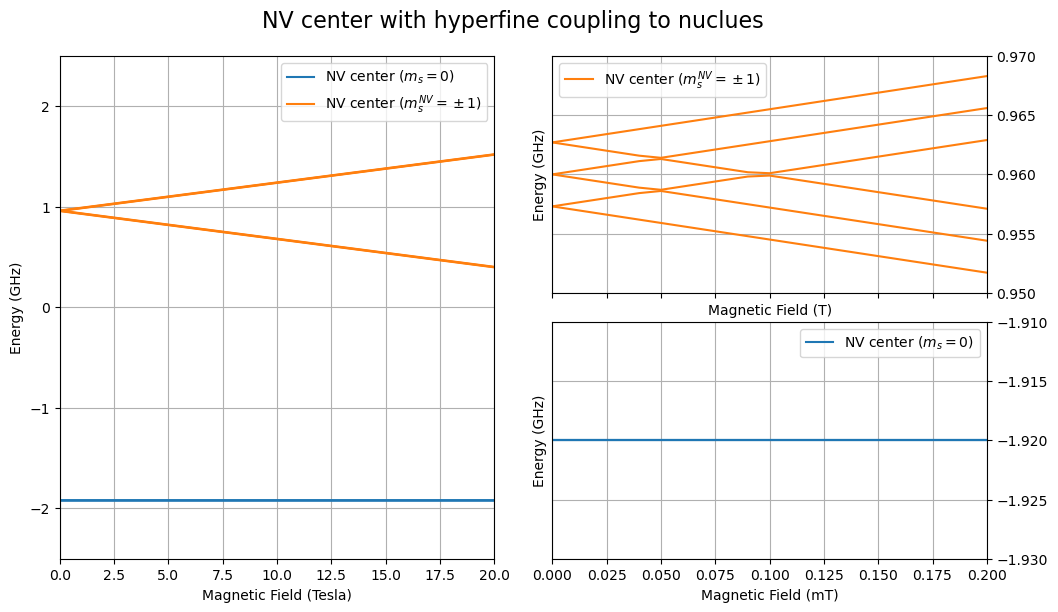

In [69]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 6), sharex=True)

fig.suptitle('NV center with hyperfine coupling to nuclues', fontsize=16)

gs = axs[0, 1].get_gridspec()
# remove the underlying axes
axs[0, 0].remove()
axs[1, 0].remove()

axbig = fig.add_subplot(gs[0:, 0])
# axbig.annotate('Big Axes \nGridSpec[1:, -1]', (0.1, 0.5),
#                xycoords='axes fraction', va='center')

fig.tight_layout()


for i in range(3):
    if i == 0:
        axbig.plot(b_fields * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), label=r'NV center ($m_s = 0$)', color='C0')
    else:
        axbig.plot(b_fields  * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), color='C0')


for i in range(6):
    if i == 0:
        axbig.plot(b_fields * 1e3, (NV_eigen_energies[i + 3, :] / 1e9).tolist(), label=r'NV center ($m^{NV}_s = \pm 1$)', color='C1')
    else:
        axbig.plot(b_fields * 1e3, (NV_eigen_energies[i + 3, :] / 1e9).tolist(), color='C1')

axbig.set_xlabel('Magnetic Field (Tesla)')
axbig.set_ylabel('Energy (GHz)')
axbig.set_xlim(0, 200e-1)
axbig.set_ylim(-2.5, 2.5)

axbig.grid()
axbig.legend()

for i in range(9):
    if i == 0:
        axs[0, 1].plot(b_fields * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), label=r'NV center ($m^{NV}_s = \pm 1$)', color='C1')
    else:
        axs[0, 1].plot(b_fields * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), color='C1')

for i in range(9):
    if i == 0:
        axs[1, 1].plot(b_fields * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), label=r'NV center ($m_s = 0$)', color='C0')
    else:
        axs[1, 1].plot(b_fields * 1e3, (NV_eigen_energies[i, :] / 1e9).tolist(), color='C0')



axs[0, 1].set_xlabel('Magnetic Field (T)')
axs[0, 1].set_ylabel('Energy (GHz)')

axs[0, 1].set_ylim(0.95, 0.97)
axs[0, 1].yaxis.tick_right()
axs[0, 1].grid()
axs[0, 1].legend()

axs[1, 1].set_xlabel('Magnetic Field (mT)')
axs[1, 1].set_ylabel('Energy (GHz)')
axs[1, 1].set_xlim(0, 2e-1)
axs[1, 1].set_ylim(-1.93, -1.91)
axs[1, 1].yaxis.tick_right()
axs[1, 1].grid()
axs[1, 1].legend()

plt.show()

fig.savefig('NV_hf_coupling.png', dpi=500, bbox_inches='tight')

### 2.3. Coupled system

In [10]:
# operators for spin NV (S=1)
NV_Sx = tensor(S1_x, qeye(2), qeye(3))
NV_Sy = tensor(S1_y, qeye(2), qeye(3))
NV_Sz = tensor(S1_z, qeye(2), qeye(3))

# operators for spin N (nitrogen electron S=1/2)
N_Sx = tensor(qeye(3), S_x, qeye(3))
N_Sy = tensor(qeye(3), S_y, qeye(3))
N_Sz = tensor(qeye(3), S_z, qeye(3))

# operators for spin I (nitrogen nuclei S=1)
I_Sx = tensor(qeye(3), qeye(2), S1_x)
I_Sy = tensor(qeye(3), qeye(2), S1_y)
I_Sz = tensor(qeye(3), qeye(2), S1_z)

In [11]:
nv_ops = (NV_Sx, NV_Sy, NV_Sz)
n_ops = (N_Sx, N_Sy, N_Sz)
i_ops = (I_Sx, I_Sy, I_Sz)

In [45]:
def system_hamiltonian(b_field: float, theta: float, distance: float, hf_coupling: float, rwa: bool = False, add_dipolar_coupling: bool = True):
    """Returns the Hamiltonian of the system.

    Args:
        b_field (float): magnetic field strength
        theta (float): angle between the magnetic field and the NV axis
        distance (float): distance between the NV center and the nitrogen nucleus

    Returns:
        Qobj: Hamiltonian of the system
    """
    H_NV = nitrogen_vacancy_hamiltonian(b_field=b_field, spin_ops=nv_ops)
    H_N = nitrogen_atom_hamiltonian(b_field=b_field, hf_coupling=hf_coupling, electron_s_ops=n_ops, nuclues_s_ops=i_ops, rwa=rwa)
    H_DIP = dipolar_coupling(theta=theta, distance=distance, nv_s_ops=nv_ops, n_s_ops=n_ops)

    if add_dipolar_coupling:
        return H_NV + H_N + H_DIP
    else:
        return H_NV + H_N

## Energy Levels

Below you can track the energy level of the NV system, as function of the magnetic field. Each field-dependent line is split, corresponding to a combination of NV and N electron spin is split due to the hyperfine interection between the N electron and the N nucleus. Increase $A$ to increase this splitting. As we zoom in on the point where the (-1,+1/2) and (0,-1/2) states, where (NV_ele,N_ele) are the spin states for the electron in the NV and the nitrogen nucleus, we see the some anticrossing as a result of the dipolar interaction. At the 'magic angle' of theta=54.7 deg this interaction leads to hybridization of the spin states, effectively leading to a flip-flop interaction between the electron spin states.

In [50]:
B_list = np.linspace(0e-4, 800e-4, 2001) # Magnetic Field in Tesla
theta = 54.7 # Angle between the N and NV electrons, relative to the magnetic field.  Degrees
A = 86e6 # Hyperfine splitting energy. Hz
energy_list = []
energy_list_uncoupled = []


for B in B_list:
    energy_at_field = system_hamiltonian(b_field=B, hf_coupling=A, theta=theta, distance=2e-9).eigenenergies()
    energy_at_field_uncoupled = system_hamiltonian(b_field=B, hf_coupling=A, theta=theta, distance=2e-9, add_dipolar_coupling=False).eigenenergies()
    energy_list.append(energy_at_field)
    energy_list_uncoupled.append(energy_at_field_uncoupled)


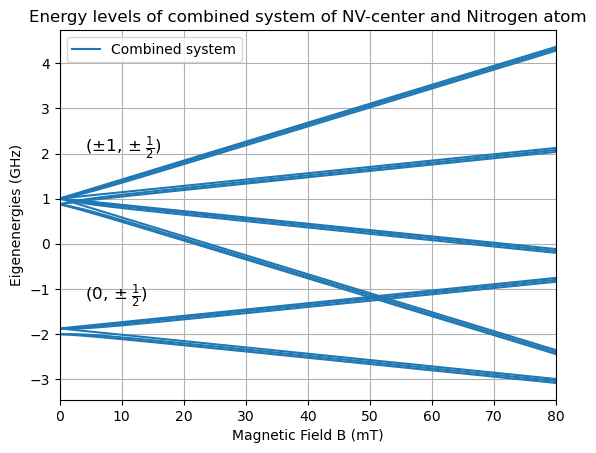

In [25]:
for i in range(6*3):
    if i == 0:
        plt.plot(B_list * 1e3, np.array(energy_list_uncoupled)[:, i] / 1e9, color='C0', label='Combined system', linestyle='-')
    else:
        plt.plot(B_list * 1e3, np.array(energy_list_uncoupled)[:, i] / 1e9, color='C0', linestyle='-')
    
# plt.plot(B_list, energy_list, color='C1', label='Combined system')
plt.ylabel('Eigenenergies (GHz)')
plt.xlabel('Magnetic Field B (mT)')
plt.title('Energy levels of combined system of NV-center and Nitrogen atom')
plt.grid()
plt.legend()

plt.xlim(0, 800e-1)

plt.annotate(r'$(0, \pm \frac{1}{2})$', (0.05, 0.28), xycoords='axes fraction', va='center', size=12)
plt.annotate(r'$(\pm 1, \pm \frac{1}{2})$', (0.05, 0.68), xycoords='axes fraction', va='center', size=12)

plt.savefig('combined_system_large_sweep.png', dpi=500, bbox_inches='tight')

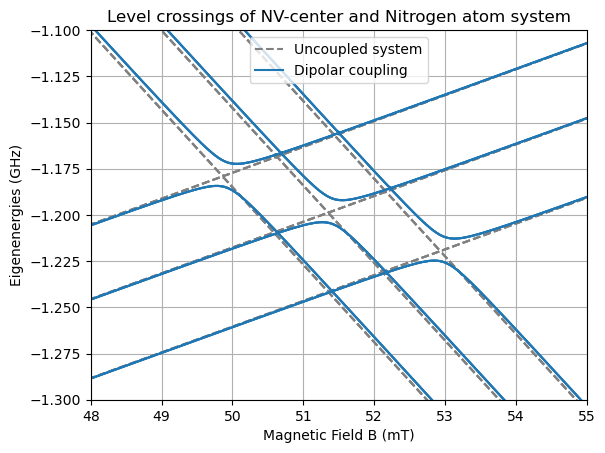

In [51]:
fig = plt.figure()

for i in range(6*3*3):
    if i == 0:
        plt.plot(B_list * 1e3, np.array(energy_list_uncoupled)[:, i] / 1e9, color='grey', label='Uncoupled system', linestyle='--')
    else:
        plt.plot(B_list * 1e3, np.array(energy_list_uncoupled)[:, i] / 1e9, color='grey', linestyle='--')

for i in range(6*3*3):
    if i == 0:
        plt.plot(B_list * 1e3, np.array(energy_list)[:, i] / 1e9, color='C0', label='Dipolar coupling', linestyle='-')
    else:
        plt.plot(B_list * 1e3, np.array(energy_list)[:, i] / 1e9, color='C0', linestyle='-')

plt.legend()
plt.title('Level crossings of NV-center and Nitrogen atom system')
plt.ylabel('Eigenenergies (GHz)')
plt.xlabel('Magnetic Field B (mT)')
plt.grid()
plt.xlim(0.048 * 1e3, 0.055 * 1e3)
plt.ylim((-1.3, -1.1))
plt.show()

fig.savefig('combined_system_zoom.png', dpi=500, bbox_inches='tight')

In [30]:
# operators for spin NV (S=1)
NV_Sx = tensor(S1_x, qeye(3), qeye(2), qeye(3))
NV_Sy = tensor(S1_y, qeye(3), qeye(2), qeye(3))
NV_Sz = tensor(S1_z, qeye(3), qeye(2), qeye(3))

# operators for spin I (nitrogen nuclei S=1)
NV_I_Sx = tensor(qeye(3), S1_x, qeye(2), qeye(3))
NV_I_Sy = tensor(qeye(3), S1_y, qeye(2), qeye(3))
NV_I_Sz = tensor(qeye(3), S1_z, qeye(2), qeye(3))

# operators for spin N (nitrogen electron S=1/2)
N_Sx = tensor(qeye(3), qeye(3), S_x, qeye(3))
N_Sy = tensor(qeye(3), qeye(3), S_y, qeye(3))
N_Sz = tensor(qeye(3), qeye(3), S_z, qeye(3))

# operators for spin I (nitrogen nuclei S=1)
I_Sx = tensor(qeye(3), qeye(3), qeye(2), S1_x)
I_Sy = tensor(qeye(3), qeye(3), qeye(2), S1_y)
I_Sz = tensor(qeye(3), qeye(3), qeye(2), S1_z)

In [31]:
nv_ops = (NV_Sx, NV_Sy, NV_Sz)
nv_i_ops = (NV_I_Sx, NV_I_Sy, NV_I_Sz)
n_ops = (N_Sx, N_Sy, N_Sz)
i_ops = (I_Sx, I_Sy, I_Sz)

In [32]:
def system_hamiltonian(b_field: float, theta: float, distance: float, hf_coupling: float, rwa: bool = False, add_dipolar_coupling: bool = True, add_hf_coupling: bool = True):
    """Returns the Hamiltonian of the system.

    Args:
        b_field (float): magnetic field strength
        theta (float): angle between the magnetic field and the NV axis
        distance (float): distance between the NV center and the nitrogen nucleus

    Returns:
        Qobj: Hamiltonian of the system
    """
    H_NV = nitrogen_vacancy_hamiltonian(b_field=b_field, spin_ops=nv_ops)
    H_NV_HF = hyperfine_coupling(hf_coupling=2.7e6, electron_s_ops=nv_ops, nuclues_s_ops=nv_i_ops)
    H_N = nitrogen_atom_hamiltonian(b_field=b_field, hf_coupling=hf_coupling, electron_s_ops=n_ops, nuclues_s_ops=i_ops, rwa=rwa)
    H_DIP = dipolar_coupling(theta=theta, distance=distance, nv_s_ops=nv_ops, n_s_ops=n_ops)

    if add_dipolar_coupling and add_hf_coupling:
        return H_NV + H_N + H_DIP + H_NV_HF
    if add_dipolar_coupling:
        return H_NV + H_N + H_DIP
    if add_hf_coupling:
        return H_NV + H_N + H_NV_HF
    else:
        return H_NV + H_N + H_NV_HF

In [43]:
B_list = np.linspace(0e-4, 800e-4, 2001) # Magnetic Field in Tesla
theta = 0 # Angle between the N and NV electrons, relative to the magnetic field.  Degrees
A = 86e6 # Hyperfine splitting energy. Hz
energy_list = []
energy_list_uncoupled = []

for B in B_list:
    energy_at_field = system_hamiltonian(b_field=B, hf_coupling=A, theta=theta, distance=2e-9).eigenenergies()
    energy_at_field_uncoupled = system_hamiltonian(b_field=B, hf_coupling=A, theta=theta, distance=2e-9, add_dipolar_coupling=False).eigenenergies()
    energy_list.append(energy_at_field)
    energy_list_uncoupled.append(energy_at_field_uncoupled)


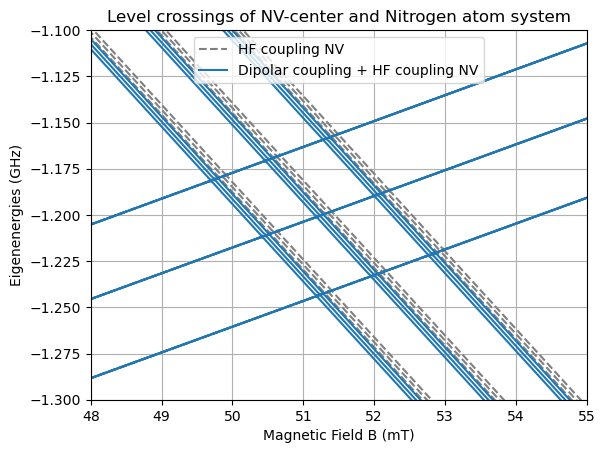

In [44]:
fig = plt.figure()

for i in range(6*3*3):
    if i == 0:
        plt.plot(B_list * 1e3, np.array(energy_list_uncoupled)[:, i] / 1e9, color='grey', label='HF coupling NV', linestyle='--')
    else:
        plt.plot(B_list * 1e3, np.array(energy_list_uncoupled)[:, i] / 1e9, color='grey', linestyle='--')

for i in range(6*3*3):
    if i == 0:
        plt.plot(B_list * 1e3, np.array(energy_list)[:, i] / 1e9, color='C0', label='Dipolar coupling + HF coupling NV', linestyle='-')
    else:
        plt.plot(B_list * 1e3, np.array(energy_list)[:, i] / 1e9, color='C0', linestyle='-')

plt.legend()
plt.title('Level crossings of NV-center and Nitrogen atom system')
plt.ylabel('Eigenenergies (GHz)')
plt.xlabel('Magnetic Field B (mT)')
plt.grid()
# plt.xlim(0.049 * 1e3, 0.054 * 1e3)
# plt.ylim((-1.25, -1.15))

plt.xlim(0.048 * 1e3, 0.055 * 1e3)
plt.ylim((-1.3, -1.1))
plt.show()

fig.savefig('combined_system_NV_HF_zoom.png', dpi=500, bbox_inches='tight')

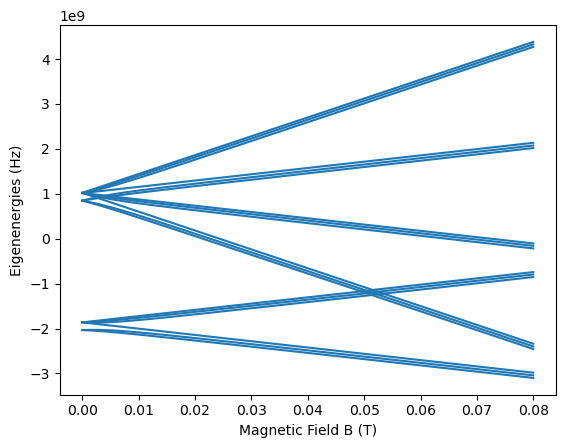

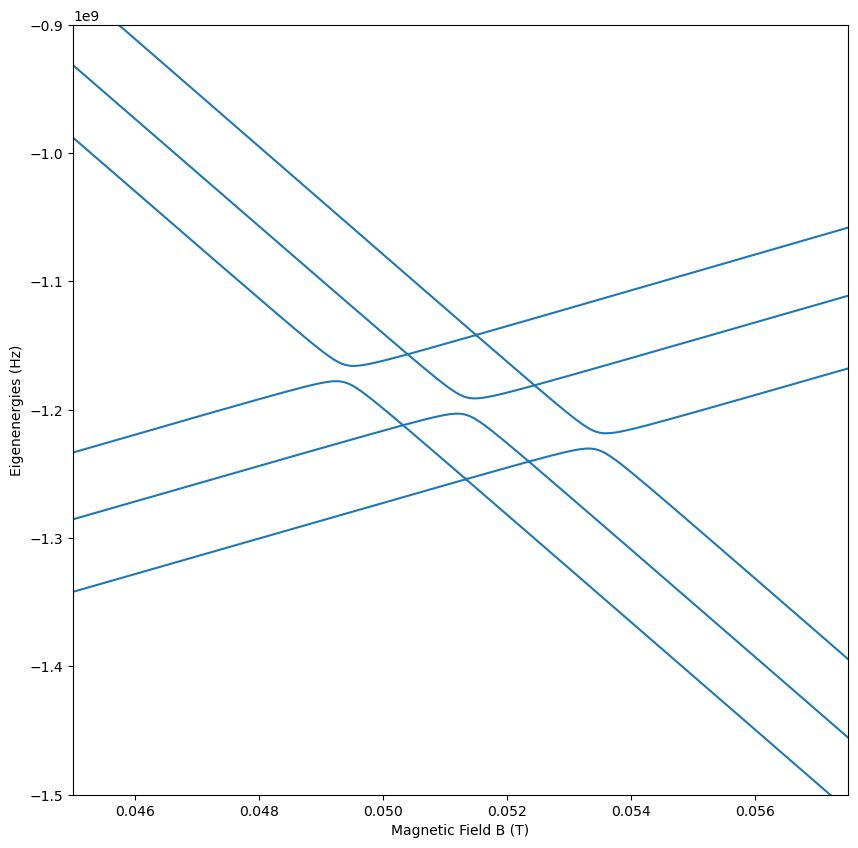

In [17]:
B_list = np.linspace(0e-4,800e-4,2001) # Magnetic Field in Tesla
theta = 54.7 # Angle between the N and NV electrons, relative to the magnetic field.  Degrees
A = 114e6 # Hyperfine splitting energy. Hz
energy_list = []
energy_list_rwa = []

for B in B_list:
    energy_at_field = system_hamiltonian(b_field=B, hf_coupling=A, theta=90, distance=2e-9).eigenenergies()
    # energy_at_field_rwa = system_hamiltonian(b_field=B, hf_coupling=A, theta=theta, distance=2e-9, rwa=True).eigenenergies()
    energy_list.append(energy_at_field)
    # energy_list_rwa.append(energy_at_field_rwa)

plt.plot(B_list, energy_list, color='C0')
# plt.plot(B_list,energy_list_rwa, color='C1')
plt.ylabel('Eigenenergies (Hz)')
plt.xlabel('Magnetic Field B (T)')
plt.show()
plt.figure(figsize=(10,10))
plt.plot(B_list,energy_list, color='C0')
# plt.plot(B_list,energy_list_rwa, color='C1')
plt.ylabel('Eigenenergies (Hz)')
plt.xlabel('Magnetic Field B (T)')
plt.xlim(0.045, 0.0575)
plt.ylim((-1.5e9, -0.9e9))
plt.show()

## Polarization of the NV Spin
Due to the hybridization at the avoided crossing, flip-flop interaction transfers the spin-state from the NV electron spin to the N electron spin. This is observed as we try to polarize the NV electron to the Spin 0 state for a particular time. Experimentally this polarization is typically done with a laser. 
The flip-flop interaction will counter-act the polarization, and leads to a higher population in the -1 spin mixture of the NV electron, as we see below. For simplicity, we exclude the hyperfine interaction here. 
Since this flip-flop interaction only occurs at the 'magic angle', and particular magnetic field, we can observe the field depedence, which we'll see below. 

This also depends on the angle $\theta$, as that dictates the flip-flop interaction!

Note: This field dependent simulation takes some time. The resolution is relatively low to speed it up a bit.

In [18]:
def qubit_integrate(b_field, hf_coupling, theta, psi0, t_list, solver, distance, g1=0, rwa=False):
    """Solve the master equation for the qubit system.

        Args:
            B (float): Global magnetic field in Tesla applied to the system
            A (float): Hyperfine constant. The value depends on magnetic field angle with respect to four C-atoms around N atom (N atom of the NV center).
            theta (float): Angle [degrees] between NV center electron and N electron in the z-x plane
            psi0 (Qobj): Initial state of the system
            t_list (array): Time points at which the system is evaluated
            solver (str): Solver used to solve the master equation. Possible values: 'me', 'es', 'mc'
            g1 (float): Dephasing rate of the system

        Returns:
            pauli_0 (tuple): Expectation values of Pauli matrices for NV center electron
            pauli_1 (tuple): Expectation values of Pauli matrices for N electron
            pauli_2 (tuple): Expectation values of Pauli matrices for N nuclei
    """

    H0 = system_hamiltonian(b_field=b_field, hf_coupling=hf_coupling, theta=theta, distance=distance, rwa=rwa)

    H = H0

    # collapse operators
    c_ops = []

    if g1 > 0.0:
        polarising_Laser = tensor(
            Qobj(np.array([[0, 0, 0], [1, 1, 1], [0, 0, 0]])), qeye(2),
            qeye(3))
        c_ops.append(np.sqrt(g1) * polarising_Laser)
        polarising_Laser = tensor(
            Qobj(np.array([[0, 0, 0], [1j, 1j, 1j], [0, 0, 0]])), qeye(2),
            qeye(3))
        c_ops.append(np.sqrt(g1) * polarising_Laser)

    g2 = 1e6  ### Some dephasing is introduced, to reduce coherent bevahiour, and focus on polarization transfer
    c_ops.append(np.sqrt(g2) * tensor(S1_z, sigmaz(), S1_z))

    e_ops = [NV_Sx, NV_Sy, NV_Sz, N_Sx, N_Sy, N_Sz, I_Sx, I_Sy, I_Sz]

    if solver == "me":
        output = mesolve(H, psi0, t_list, c_ops, e_ops)
    elif solver == "es":
        output = essolve(H, psi0, t_list, c_ops, e_ops)
    elif solver == "mc":
        ntraj = 250
        output = mcsolve(H, psi0, t_list, c_ops, e_ops, ntraj=ntraj)
    else:
        raise ValueError("unknown solver")

    pauli_0 = (output.expect[0], output.expect[1], output.expect[2])
    pauli_1 = (output.expect[3], output.expect[4], output.expect[5])
    pauli_2 = (output.expect[6], output.expect[7], output.expect[8])

    return pauli_0, pauli_1, pauli_2

In [19]:
A = 0*86e6
B_list = np.linspace(460e-4,560e-4,150)
theta = 54.7

rho0 = tensor(qeye(3) / 3, qeye(2) / 2,qeye(3) / 2) # Initialising in a maximally mixed state
g1 = 1e6 #Rate of the polarization due to the 'laser'

tlist = np.linspace(0, 1/g1, 1000) #Time the 'laser' is applied

pol_NV_all = np.zeros(B_list.size)
pol_N_ele_all = np.zeros(B_list.size)
pol_N_nuc_all = np.zeros(B_list.size)

for idx,B in enumerate(B_list):
    expect_0, expect_1, expect_2 = qubit_integrate(b_field=B, hf_coupling=A, theta=theta, psi0=rho0, t_list=tlist, solver="me", distance=2e-9, g1=g1)
    pol_NV = expect_0[2][-1]
    pol_N_ele = expect_1[2][-1]
    pol_N_nuc = expect_2[2][-1]
    
    pol_NV_all[idx] = pol_NV
    pol_N_ele_all[idx] = pol_N_ele
    pol_N_nuc_all[idx] = pol_N_nuc
    
    if (idx+1) % 5==0:
        print(f'Field dependent simulation at {100*(idx+1)/B_list.size}%')

Field dependent simulation at 3.3333333333333335%
Field dependent simulation at 6.666666666666667%
Field dependent simulation at 10.0%
Field dependent simulation at 13.333333333333334%
Field dependent simulation at 16.666666666666668%
Field dependent simulation at 20.0%
Field dependent simulation at 23.333333333333332%
Field dependent simulation at 26.666666666666668%
Field dependent simulation at 30.0%
Field dependent simulation at 33.333333333333336%
Field dependent simulation at 36.666666666666664%
Field dependent simulation at 40.0%
Field dependent simulation at 43.333333333333336%
Field dependent simulation at 46.666666666666664%
Field dependent simulation at 50.0%
Field dependent simulation at 53.333333333333336%
Field dependent simulation at 56.666666666666664%
Field dependent simulation at 60.0%
Field dependent simulation at 63.333333333333336%
Field dependent simulation at 66.66666666666667%
Field dependent simulation at 70.0%
Field dependent simulation at 73.33333333333333%
F

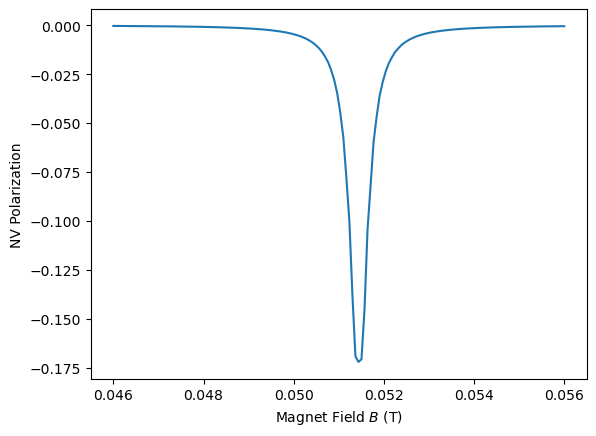

In [20]:
plt.plot(B_list,pol_NV_all)
plt.xlabel('Magnet Field $B$ (T)')
plt.ylabel('NV Polarization')

plt.show()

## Effect of Nuclear Polarization
Now let us reintroduce the hyperfine interaction. We will see that the electron energies are split due to the hyperfine interaction, and hence the resonant energy of the (-1,1/2)-(0,-1/2) electron-spin transition has changed. In particular the polarization rate of the NV electron is now decreased at three different magnetic fields (at which the flip-flop interaction takes place). This is seen in the code below.

What happens if the nuclear spin is polarized? Change the density matrix corresponding to the nuclear spin, and polarize it somewhat (e.g. Qobj(np.array([[0.7, 0, 0],[0, 1, 0],[0, 0, 1.2]])/3)

Notice that the peaks change height correspondingly, as is observed in the paper by Hanson et al. Depending on the polarization of the nuclear spin, some transitions are available or not! One can use this to read out the spin-state of the nuclear spin. As hypothesised by Hanson et al. the nuclear spin is initially due to the hyperfine interaction between the electron and nuclear spin. This would imply possible control over the nuclear spin, which is crucial if we want to use it as a qubit. Control over the nuclear spin using this hyperfine interaction has indeed been shown (e.g. Bradley et al. Phys. Rev. X 9, 031045)


In [21]:
A = 86e6
B_list = np.linspace(480e-4,550e-4,150)
# B_list = np.linspace(300e-4,700e-4,150)
theta = 54.7 # In degress

###
### Initialising in a maximally mixed state
rho0 = tensor(qeye(3)/3, qeye(2)/2,qeye(3)/2 ) 
###
# ###
# ### Initialising in a slightly polarised state
rho0_1 = tensor(qeye(3)/3, qeye(2)/2, Qobj(np.array([[0.7, 0, 0],[0, 1, 0],[0, 0, 1.2]]) / 3)) 
# ###

g1 = 1e6 #Rate of the polarization due to the 'laser'

tlist = np.linspace(0,1/g1/2,1000) # Time the 'laser' is applied

pol_NV_all = np.zeros(B_list.size)
pol_N_ele_all = np.zeros(B_list.size)
pol_N_nuc_all = np.zeros(B_list.size)

pol_NV_all_1 = np.zeros(B_list.size)
pol_N_ele_all_1 = np.zeros(B_list.size)
pol_N_nuc_all_1 = np.zeros(B_list.size)

for idx,B in enumerate(B_list):
    expect_0, expect_1, expect_2 = qubit_integrate(b_field=B, hf_coupling=A, theta=theta, psi0=rho0, t_list=tlist, solver="me", distance=2e-9, g1=g1)
    expect_0_1, expect_1_1, expect_2_1 = qubit_integrate(b_field=B, hf_coupling=A, theta=theta, psi0=rho0_1, t_list=tlist, solver="me", distance=2e-9, g1=g1)
    # expect_0_rwa, expect_1_rwa, expect_2_rwa = qubit_integrate(b_field=B, hf_coupling=A, theta=theta, psi0=rho0, t_list=tlist, solver="me", distance=2e-9, g1=g1, rwa=True)
    pol_NV = expect_0[2][-1]
    pol_N_ele = expect_1[2][-1]
    pol_N_nuc = expect_2[2][-1]
    
    pol_NV_1 = expect_0_1[2][-1]
    pol_N_ele_1 = expect_1_1[2][-1]
    pol_N_nuc_1 = expect_2_1[2][-1]
    
    pol_NV_all[idx] = pol_NV
    pol_N_ele_all[idx] = pol_N_ele
    pol_N_nuc_all[idx] = pol_N_nuc
    
    pol_NV_all_1[idx] = pol_NV
    pol_N_ele_all_1[idx] = pol_N_ele
    pol_N_nuc_all_1[idx] = pol_N_nuc
    
    if (idx+1) % 5==0:
        print(f'Field dependent simulation at {100*(idx+1)/B_list.size}%')



Field dependent simulation at 3.3333333333333335%
Field dependent simulation at 6.666666666666667%
Field dependent simulation at 10.0%
Field dependent simulation at 13.333333333333334%
Field dependent simulation at 16.666666666666668%
Field dependent simulation at 20.0%
Field dependent simulation at 23.333333333333332%
Field dependent simulation at 26.666666666666668%
Field dependent simulation at 30.0%
Field dependent simulation at 33.333333333333336%


KeyboardInterrupt: 

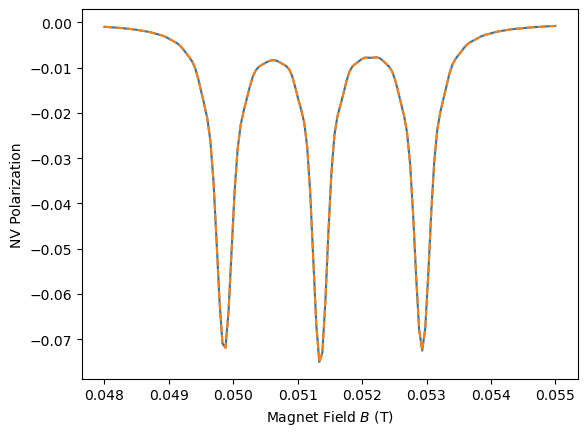

In [ ]:
plt.plot(B_list, pol_NV_all)
plt.plot(B_list, pol_NV_all_1, linestyle='--')
plt.xlabel('Magnet Field $B$ (T)')
plt.ylabel('NV Polarization')

plt.show()